# Example case of simulating observations of a cluster with multiple pointings #

This thread shows how to use _M2_ProposalTools_ to simulate observations of a target.

In [1]:
### Useful libraries
import numpy as np
import astropy.units as u
from astropy.io import fits 
#### Modules within our library
import M2_ProposalTools.WorkHorse as WH
import M2_ProposalTools.MakeRMSmap as MRM
import M2_ProposalTools.ModelFitting as MF
from astropy.wcs import WCS
import os
from scipy.ndimage import filters

Supply an output directory.

In [2]:
outdir="/home/data/MUSTANG2/SimulatedObservations/LightWeight/"

Let's define some options for the input cluster, mapping parameters, and scanning strategy

If an entry in offsets is greater than zero, then the scan strategy is taken to be a set of four scans which are offset by the respective distance, in arcminutes, from the central pointing towards: (1) the west, (2) north, (3) east, and (4) south.

In [3]:
WHpath   = os.path.abspath(WH.__file__)
HDUpath  = WHpath.replace("WorkHorse.py","")
FileName = "a1.0005_cl00003_proj_z_SZonly.fits.gz"
SkyFile  = os.path.join(HDUpath,FileName)
SkyHDU   = fits.open(SkyFile)

In [4]:
SZext    = 1                                 # The Compton y map is in the second extension (index = 1)
Redshift = SkyHDU[SZext].header["REDSHIFT"]  # The simulation recorded this image at this redshift
print(Redshift)                              

0.01


In [5]:
myWCS    = WCS(SkyHDU[SZext].header)                        # Get the WCS information
print(myWCS.wcs.cdelt)                                      # Pixel size information
print(myWCS.wcs.cunit)                                      # Note that the units are not degrees
print(myWCS.wcs.crval)                                      # Check units of CRVAL
print("Reference, in pixel coordinates: ",myWCS.wcs.crpix)  # Check units of CRPIX
print("Shape of image: ",SkyHDU[SZext].shape)               # Check shape of the image
print(myWCS.wcs.ctype)                                      # Check the type of projection

[5.45236651 5.45236651]
['kpc', 'kpc']
[659772.86778532 623087.80682914]
Reference, in pixel coordinates:  [1024.5 1024.5]
Shape of image:  (2048, 2048)
['linear', 'linear']


The lightweight observing suite assumes that the units are in degrees. Even though there are a second set of coordinate deltas (CRDELT1A and CRDELTA2A) in the header which are in degrees, the observing suite is not built to find potential secondary coordinates. Even if it were, we might want to change the redshift so that the cluster is not quite so large on the sky. 

Note, the Compton y signal itself is redshift independent, so we don't face an intrinsic problem in changing the redshift of a simulated observation. Of course, it's possible that you then see a cluster at a stage in evolution which is not fully correct for that redshift, but for the point of demonstrating what this tool requires as in input HDU file, we can proceed.

In [6]:
z        = 0.3                     # Let's push the cluster to this redshift
d_ang    = WH.get_d_ang(z)         # angular distance
d_a_kpc  = d_ang.to("kpc").value
r2d      = u.rad.to("deg")

In [7]:
# Now we can redo the WCS information
cdelt    = [cdin*r2d/d_a_kpc for cdin in myWCS.wcs.cdelt]
myWCS.wcs.cdelt = cdelt            # Set the updated values
myWCS.wcs.cunit = ["deg","deg"]    # Set the updated units
myWCS.wcs.crval = [180.,45.]       # Coordinates in degrees: (RA,Dec). Largely an arbitrary choice for this suite.
myWCS.wcs.ctype = ['RA---TAN','DEC--TAN']
myWCS.wcs.lonpole  = 180           # Might as well put the pole close to our object
myWCS.wcs.latpole  = 45            # Might as well put the pole close to our object
#myWCS.wcs.crpix = []              # Not needed; CRPIX was near the center of the image.

In [8]:
pixsize  = np.array(cdelt)*3600    # for those of us who don't think in degrees
print(pixsize)                     # it may be easier to parse arcseconds

[1.22409959 1.22409959]


This astrometry seems fine. It's definitely a higher resolution than necessary; one could `reproject` it to have larger pixels if a smaller array is desired.

We'll proceed with this and smooth it by the MUSTANG-2 beam

In [9]:
M2sky    = WH.smooth_by_M2_beam(SkyHDU[SZext].data,pixsize=pixsize[0])  # Smooth by the MUSTANG-2 beam

The simulation map was in Compton $y$; We'll perform a rough conversion to (micro)Kelvin (Rayleigh-Jeans), the default units for MUSTANG-2 sensitivities used in this package.

In [10]:
y2k      = -3.4            # Conversion from Compton y to Kelvin (RJ) for kT_e ~ 7 keV; good for most clusters
M2_uK    = M2sky*y2k*1e6   # Now you have a sky map with respect to MUSTANG-2, in units of microKelvin (RJ)                      

Let's make a new HDUList to use in making our sensitivity (RMS) map.

In [11]:
NewHdr      = myWCS.to_header()       # New header
NewSkyM2    = fits.PrimaryHDU(M2_uK,header=NewHdr)
NewSkyOrig  = fits.ImageHDU(SkyHDU[SZext].data,header=NewHdr)
NewSky      = fits.HDUList([NewSkyM2,NewSkyOrig])         # Make it a list

Your choice on what to put in the filename. Saving is not obligatory, but it's probably useful.

In [12]:
pixstr = "{:.1f}".format(pixsize[0]).replace(".","p")
zstr   = "{:.1f}".format(z).replace(".","z")
Mstr   = "CL00003"
SkyName = "_".join([Mstr,pixstr,zstr])

In [13]:
Skyname = "FromNumericalSimulation_"+SkyName+".fits"
NewSky.writeto(outdir+Skyname,overwrite=True)

Once again, we can define our scanning strategy.

In [14]:
times    = [5,5]                              # A list of time per scan strategy, in hours
ptgs     = [myWCS.wcs.crval,myWCS.wcs.crval ] # A list of centroid pairs (RA,Dec) in degrees
sizes    = [3.5,3.5]               # Scan sizes, in arcminutes
offsets  = [1.5,0]                 # Pointing offsets, in arcminutes.

The above image is what MUSTANG-2 would see if data processing imparted no filtering effects. Unfortunately, data processing does act as a filter, and so we combined the filtering effects with the sensitivity mapmaking in the following routine. It returns two HDULists. The first HDUList has a filtered map and a corresponding weight map, where the weight map is the inverse variance. The second HDUList is the same, but the filtered map has an additional smoothing. This smoothing is the standard smoothing applied to final MIDAS maps; it is with this smoothing that the inverse variance maps, as calculated, are appropriate comparisons.

In [15]:
FilterHDU,SmoothHDU = WH.lightweight_simobs_hdu(NewSky,ptgs=ptgs,sizes=sizes,times=times,offsets=offsets,center=None,WIKID=False)

Depending on what you want to track, this adds some information to the filenames

In [16]:
sss    = ["{:.1f}".format(mysz).replace(".","s") for mysz in sizes]
sts    = ["{:.1f}".format(mytime).replace(".","h") for mytime in times]
ssstr  = "_".join(sss)
ststr  = "_".join(sts)
InputStr = "_".join([zstr,Mstr,ssstr,ststr,pixstr])

Saving to fits files may be desirable.

In [17]:
filename = "SimulatedObs_Unsmoothed_"+InputStr+".fits"
FilterHDU.writeto(outdir+filename,overwrite=True)
filename2 = "SimulatedObs_Smoothed_"+InputStr+".fits"
SmoothHDU.writeto(outdir+filename2,overwrite=True)

Now, part of the reason to pass in a simulated HDU is not just to use its astrometry, but to see where features may align in the RMS map.
From a previous notebook, one might recall that the RMS plotting routine will assume the second extension in an HDUList is a weight map and calculate an RMS map from that. To decouple us from that assumption, we can explicitly calculate the RMS map:

In [18]:
RMSmap = np.zeros(FilterHDU[1].data.shape)
nzwts  = (FilterHDU[1].data > 0)
RMSmap[nzwts] = 1.0/np.sqrt(FilterHDU[1].data[nzwts])

And now we want to make an image which will itself highlight the features we want, or when passed through a GGM filter can highlight features.

Below, I've just played around by hand to get a file that will highlight features when a GGM filter is applied.

I define one mask which I already apply to the image, and a second one which will be applied *after* the GGM filter is applied. The latter is smaller than the first so that we're not picking up on the edge of the former mask.

In [19]:
HeavilySmoothed = filters.gaussian_filter(NewSky[1].data, 25)
HSxymap         = MRM.make_xymap(NewSky[1].data,NewSky[1].header,*myWCS.wcs.crval)
HSrmap          = MRM.make_rmap(HSxymap) # In arcminutes
MyMask          = np.ones(HSrmap.shape)
zind            = (HSrmap > 7)   # Mask anything more than 7 arcminutes away from the center.
MyMask[zind]    = 0
NewSky[0].data = MyMask*NewSky[1].data / HeavilySmoothed

In [20]:
ggmMask         = np.ones(HSrmap.shape)
zind            = (HSrmap > 6.5)   # Mask anything more than 6.5 arcminutes away from the center.
ggmMask[zind]    = 0

For this example, the very center of the map gets down to 20.2 $\mu$K. We'll set ggm=True so that the routine takes the GGM of the imgext extension of NewSky. We only need one contour, so ncnts=1.

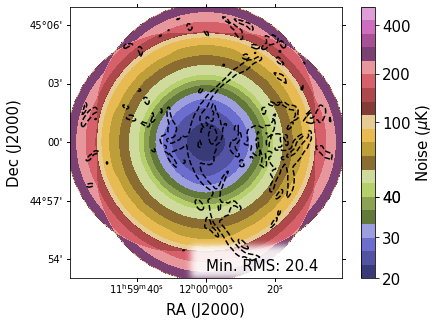

In [21]:
pngname  = "SimulatedObservations_MUSTANG-2_"+InputStr+"_RMSimage.png"
vmin     = 20.0  # uK
vmax     = 520.0 # uK
MRM.plot_rms_general(NewSky,outdir+pngname,ncnts=1,ggm=True,rmsmap=RMSmap,vmin=vmin,vmax=vmax,prntinfo=True,zoom=3,imgext=0,ggmIsImg=False,mask=ggmMask)